In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
import io

## Downloading and preprocessing the data





Download the IMDB Reviews raw data

In [2]:
import urllib.request
import tarfile
thetarfile = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
ftpstream = urllib.request.urlopen(thetarfile)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall()

Get the file paths for all of the reviews so that we can read the reviews from each text file and put them together into one large dataset

In [3]:
# Get the file names from a particular folder
import os             
train_files_pos = os.listdir('./aclImdb/train/pos')
print(train_files_pos[0:5])

['6662_7.txt', '11410_7.txt', '2244_9.txt', '4993_10.txt', '3806_8.txt']


In [4]:
# Gets the entire file path
import glob
train_pos_txt_files = glob.glob('./aclImdb/train/pos/*.txt')
train_neg_txt_files = glob.glob('./aclImdb/train/neg/*.txt')
test_pos_txt_files = glob.glob('./aclImdb/test/pos/*.txt')
test_neg_txt_files = glob.glob('./aclImdb/test/neg/*.txt')
print(train_pos_txt_files[0:3])
pos_files = [train_pos_txt_files, test_pos_txt_files]
neg_files = [train_neg_txt_files, test_neg_txt_files]

['./aclImdb/train/pos/6662_7.txt', './aclImdb/train/pos/11410_7.txt', './aclImdb/train/pos/2244_9.txt']


The reviews contain HTML tags, so we remove them

In [5]:
import re

def clean_html(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext.lower() # the tokenizer converts to lowercase as a default

Remove HTML tags from all reviews and store the reviews as strings in a list

In [6]:
pos_reviews = []
neg_reviews = []
for collection in pos_files:
  for path in collection:
    with open(path, 'r') as f:
      pos_reviews.append(clean_html(f.read()))
for collection in neg_files:
  for path in collection:
    with open(path, 'r') as f:
      neg_reviews.append(clean_html(f.read()))

Create training, validation, and test sets

In [7]:
train_revs = pos_reviews[:20000] + neg_reviews[:20000]
train_labels = [1]*20000 + [0]*20000
valid_revs = pos_reviews[20000:22500]+neg_reviews[20000:22500]
valid_labels = [1]*2500 + [0]*2500
test_revs = pos_reviews[22500:]+neg_reviews[22500:]
test_labels = [1]*2500 + [0]*2500

Shuffle the data prior to training. We only need to shuffle the training and validation data

In [8]:
def shuffle_data(x,y):
  data = list(zip(x,y))
  random.shuffle(data)
  return zip(*data)

In [9]:
train_revs, train_labels = shuffle_data(train_revs, train_labels)

valid_revs, valid_labels = shuffle_data(valid_revs, valid_labels)

test_revs, test_labels = shuffle_data(test_revs, test_labels)

Tokenize and pad the reviews

In [10]:
# these same parameters are used in every model
vocab_size = 20000
max_length = 500
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_revs)
word_index = tokenizer.word_index

# switch key, value for the word index so that we can use the token (number) as the key
# look up the corresponding word
word_index = dict([(value,key) for key, value in word_index.items()])

In [11]:
def toke_and_pad(sentences, max_len = 500, trunc_type = 'post', pad_type = 'post'):
  tokenized = tokenizer.texts_to_sequences(sentences)
  tokenized_and_padded = pad_sequences(tokenized, maxlen=max_len, truncating=trunc_type, padding=pad_type)
  return tokenized_and_padded

In [12]:
# Pad the sequences so that they are all the same length
x_train = toke_and_pad(train_revs)
x_valid = toke_and_pad(valid_revs)
x_test = toke_and_pad(test_revs)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Create Tensorflow Dataset and batch the data for quicker training

In [13]:
train = tf.data.Dataset.from_tensor_slices((x_train, train_labels)) 
valid = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))
test = tf.data.Dataset.from_tensor_slices((x_test, test_labels))

In [14]:
train = train.shuffle(50000).batch(128).prefetch(1)
valid = valid.shuffle(50000).batch(128).prefetch(1)

## Define functions for training

In [15]:
def plot_training_metrics(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Acc')
  plt.plot(epochs_range, val_acc, label='Validation Acc')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Acc')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  plt.close()

In [16]:
def get_embed_visual_files(model):
  # First get the weights of the embedding layer
  e = model.layers[0]
  weights = e.get_weights()[0]
  print(weights.shape) # shape: (vocab_size, embedding_dim)

  # Write out the embedding vectors and metadata
  out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
  out_m = io.open('meta.tsv', 'w', encoding='utf-8')
  for word_num in range(1, vocab_size):
    word = word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
  out_v.close()
  out_m.close()

  # Download the files
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

In [17]:
def fit_model(model, return_preds = False, num_epochs = 100): # input a compiled model
  # the input_dim and the input_length of the embedding layer
  # must match the vocab size and max length parameters of the Tokenizer, respectively
  # the same training, validation, and test sets are used
  early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                              restore_best_weights = True, patience = 5)
  # check_point = tf.keras.callbacks.ModelCheckpoint('model_checkpoint', monitor = 'val_accuracy', save_weights_only = True, save_freq = 'epoch')
  model.summary()
  history = model.fit(train, 
          epochs=num_epochs, 
          validation_data=valid,
          callbacks = [early_stop],
          verbose = 0) # early stopping will be used in training every model
  plot_training_metrics(history)
  test_acc = model.evaluate(x_test, test_labels)
  print('The accuracy of this model on the unseen test set is {}'.format(round(test_acc[1],4)))
  if return_preds == True:
    pred_proba = model.predict(x_test)
    pred_labels = [0 if p < 0.5 else 1 for p in pred_proba]
    return history, pred_labels
  else:
    return history

In [18]:
def print_incorrect_preds(pred_labels, true_labels, num=5): # print some of the reviews which are incorrectly classified by a model
  j = 0
  for i in range(len(pred_labels)):
    if j < num:
      if pred_labels[i] == test_labels[i]:
        continue
      else:
        j += 1
        print('The following review is predicted to be {}, but it is {}'.format(pred_labels[i], test_labels[i]))
        print((test_revs[i]))
        print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          2560000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,562,081
Trainable params: 2,562,081
Non-trainable params: 0
_________________________________________________________________


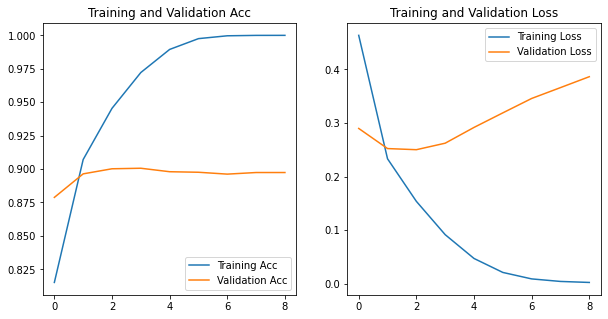

157/157 [==============================] - 1s 3ms/step - loss: 0.2606 - accuracy: 0.9038
The accuracy of this model on the unseen test set is 0.9038


In [19]:
tf.keras.backend.clear_session()
embedding_dim = 128
embedding_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
embedding_model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

embedding_history, embed_preds = fit_model(embedding_model,return_preds = True)

In [20]:
print_incorrect_preds(embed_preds, test_labels)

The following review is predicted to be 0, but it is 1
a bunch of mostly obnoxious and grossly unappealing teens go to a creepy, remote, rundown old mortuary located nearby a cemetery to attend an anything-goes all-out halloween party being hosted by freaky occult-obsessed oddball mimi kinkade and her vacuous, boy-hungry bimbette friend linnea quigley. the loutish, profane, beer-guzzling, sex-happy dipstick dimwits hold a séance as a joke (very bad idea, 'cause the desolate old dive is naturally said to be haunted by demonic spirits). of course, that ill-advised séance awakens those decidedly grumpy and hostile evil spirits, who gruesomely kill and possess a majority of the kids, turning them into ugly, fanged, clawed, boil-faced murderous ghouls who wreak the usual grisly havoc throughout the duration of an especially long, dark and harrowing night of pure terror.yep, this is essentially your umpteenth vigorously graphic and unrelenting wall-to-wall cheap shock-ridden "evil dead" reha

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 16)           10256     
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 2,570,273
Trainable params: 2,570,273
Non-trainable params: 0
_________________________________________________________________


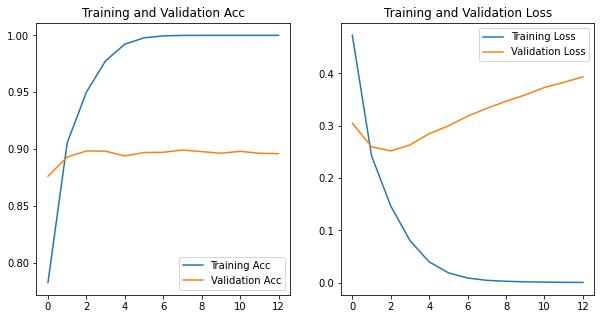

157/157 [==============================] - 1s 4ms/step - loss: 0.3746 - accuracy: 0.8896
The accuracy of this model on the unseen test set is 0.8896


In [21]:
tf.keras.backend.clear_session()

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
cnn_history, cnn_preds = fit_model(model_cnn, return_preds = True)

In [22]:
print_incorrect_preds(cnn_preds, test_labels)

The following review is predicted to be 0, but it is 1
a bunch of mostly obnoxious and grossly unappealing teens go to a creepy, remote, rundown old mortuary located nearby a cemetery to attend an anything-goes all-out halloween party being hosted by freaky occult-obsessed oddball mimi kinkade and her vacuous, boy-hungry bimbette friend linnea quigley. the loutish, profane, beer-guzzling, sex-happy dipstick dimwits hold a séance as a joke (very bad idea, 'cause the desolate old dive is naturally said to be haunted by demonic spirits). of course, that ill-advised séance awakens those decidedly grumpy and hostile evil spirits, who gruesomely kill and possess a majority of the kids, turning them into ugly, fanged, clawed, boil-faced murderous ghouls who wreak the usual grisly havoc throughout the duration of an especially long, dark and harrowing night of pure terror.yep, this is essentially your umpteenth vigorously graphic and unrelenting wall-to-wall cheap shock-ridden "evil dead" reha

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49920     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,330,049
Trainable params: 1,330,049
Non-trainable params: 0
_________________________________________________________________


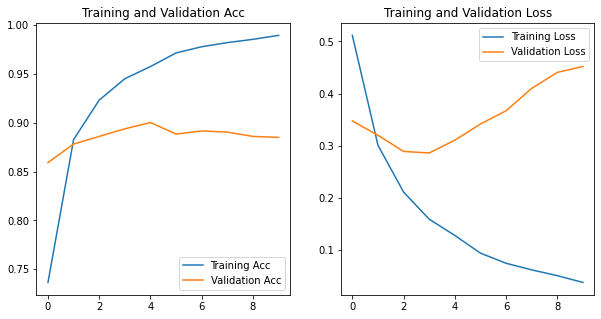

157/157 [==============================] - 2s 14ms/step - loss: 0.3301 - accuracy: 0.8882
The accuracy of this model on the unseen test set is 0.8882


In [23]:
tf.keras.backend.clear_session()

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

gru_history, gru_preds = fit_model(model_gru, return_preds = True)

In [24]:
print_incorrect_preds(gru_preds, test_labels)

The following review is predicted to be 0, but it is 1
a bunch of mostly obnoxious and grossly unappealing teens go to a creepy, remote, rundown old mortuary located nearby a cemetery to attend an anything-goes all-out halloween party being hosted by freaky occult-obsessed oddball mimi kinkade and her vacuous, boy-hungry bimbette friend linnea quigley. the loutish, profane, beer-guzzling, sex-happy dipstick dimwits hold a séance as a joke (very bad idea, 'cause the desolate old dive is naturally said to be haunted by demonic spirits). of course, that ill-advised séance awakens those decidedly grumpy and hostile evil spirits, who gruesomely kill and possess a majority of the kids, turning them into ugly, fanged, clawed, boil-faced murderous ghouls who wreak the usual grisly havoc throughout the duration of an especially long, dark and harrowing night of pure terror.yep, this is essentially your umpteenth vigorously graphic and unrelenting wall-to-wall cheap shock-ridden "evil dead" reha

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,346,177
Trainable params: 1,346,177
Non-trainable params: 0
_________________________________________________________________


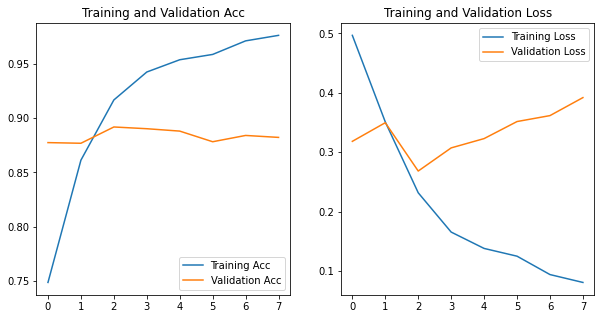

157/157 [==============================] - 2s 14ms/step - loss: 0.2787 - accuracy: 0.8896
The accuracy of this model on the unseen test set is 0.8896


In [25]:
tf.keras.backend.clear_session()

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

lstm_history, lstm_preds = fit_model(model_lstm, return_preds = True)

In [26]:
print_incorrect_preds(lstm_preds, test_labels)

The following review is predicted to be 0, but it is 1
a bunch of mostly obnoxious and grossly unappealing teens go to a creepy, remote, rundown old mortuary located nearby a cemetery to attend an anything-goes all-out halloween party being hosted by freaky occult-obsessed oddball mimi kinkade and her vacuous, boy-hungry bimbette friend linnea quigley. the loutish, profane, beer-guzzling, sex-happy dipstick dimwits hold a séance as a joke (very bad idea, 'cause the desolate old dive is naturally said to be haunted by demonic spirits). of course, that ill-advised séance awakens those decidedly grumpy and hostile evil spirits, who gruesomely kill and possess a majority of the kids, turning them into ugly, fanged, clawed, boil-faced murderous ghouls who wreak the usual grisly havoc throughout the duration of an especially long, dark and harrowing night of pure terror.yep, this is essentially your umpteenth vigorously graphic and unrelenting wall-to-wall cheap shock-ridden "evil dead" reha

If we want to use these models to predict sentiment on new reviews, we need to put those reviews into a list and we need to process (tokenize and pad) the reviews 

In [27]:
new_revs = ['this movie was really bad. I hated it and it might be the worst thing ever',
            'Oh boy it was too long and it was far from the best',
            'Boy and girl meet and fall in love. They go out on dates and eat food. If you like romance, then you will like this movie. It was excellent',
            'I expected this movie to be really bad, but I was pleasantly surprised. The movie is a little too long and some of the jokes are bad, but overall it was good.']

new_revs = toke_and_pad(new_revs)

In [28]:
embedding_model.predict(new_revs)

array([[0.013524  ],
       [0.43225908],
       [0.95475096],
       [0.9747034 ]], dtype=float32)

In [29]:
model_cnn.predict(new_revs)

array([[5.3655299e-07],
       [9.8578507e-01],
       [9.9925202e-01],
       [9.9611795e-01]], dtype=float32)

In [30]:
model_gru.predict(new_revs)

array([[0.00954004],
       [0.37681973],
       [0.96825045],
       [0.85453814]], dtype=float32)

In [31]:
model_lstm.predict(new_revs)

array([[0.02070332],
       [0.2938824 ],
       [0.8498731 ],
       [0.80451596]], dtype=float32)